# **Proyecto Analitica de Datos : "Music Genre Classification"** 

**Brayan Stid Valencia Quintero**

# Inicio códigos

Primero se debe importar todas las librerias necesarias 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
warnings.filterwarnings('ignore')

Como se accedera a la base de datos desde kaggle, es necesario instalarlo

In [ ]:
! pip install kaggle

Es necesario cargar el archivo "kaggle.json" para poder tener acceso a la base de datos 

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brayanv","key":"834f4119f8f316fd5801f2e4e6400dbc"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:34<00:00, 33.9MB/s]
100% 1.21G/1.21G [00:34<00:00, 37.4MB/s]


In [ ]:
!unzip gtzan-dataset-music-genre-classification.zip 
!dir

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

In [ ]:
import os
general_path = '/content/Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['pop', 'blues', 'disco', 'country', 'metal', 'jazz', 'rock', 'classical', 'reggae', 'hiphop']


Podemos observar que hay 10 diferentes generos:
- Pop
- Blues
- Disco
- Country
- Metal
- Jazz
- Rock
- Classical
- Reggae
- HipHop

Ahora vamos a explorar los datos, como es de esperarse por el titulo del proyecto, los datos son de audio.

Usaremos librosa, para facilitar el trato con los datos de audio 

Comprender el audio

Exploremos nuestros datos de audio para ver cómo se ven (trabajaremos con el archivo reggae.00036.wav).

Sonido: secuencia de vibraciones en fuerzas de presión variables (y)
La frecuencia de muestreo (sr) es el número de muestras de audio transportadas por segundo, medido en Hz o kHz

In [ ]:
y, sr = librosa.load(f'{general_path}/genres_original/reggae/reggae.00036.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verificar la duración del audio
print('Check Len of Audio:', 661794/22050)

y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [ ]:
audio_file, _ = librosa.effects.trim(y)

# El resultado es un  numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


Representación 2D: ondas sonoras 


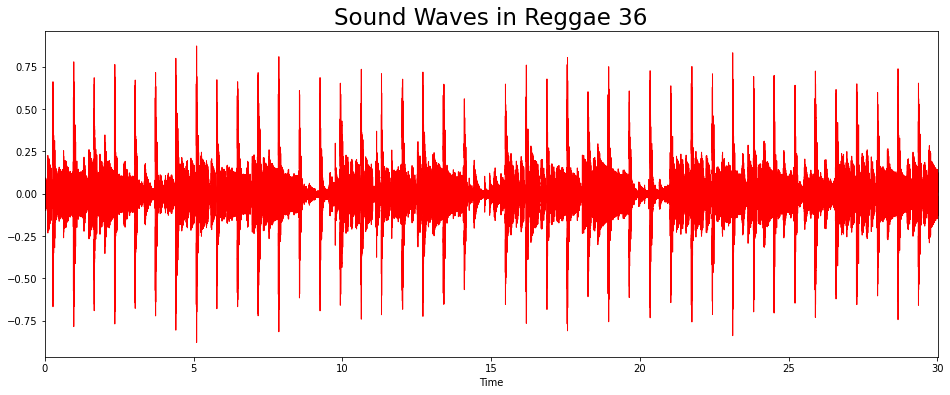

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = audio_file, sr = sr, color = "r");
plt.title("Sound Waves in Reggae 36", fontsize = 23);

**Transformada de Fourier**

Función que recibe una señal en el dominio del tiempo como entrada y genera su descomposición en frecuencias
Transforme tanto el eje y (frecuencia) a escala logarítmica como el eje de "color" (amplitud) a decibelios, que es aprox. la escala logarítmica de amplitudes.

In [ ]:
# Tamaño de ventana FFT predeterminado
n_fft = 2048 # FFT tamaño ventana
hop_length = 512 

 
#Transformada de Fourier de tiempo corto (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


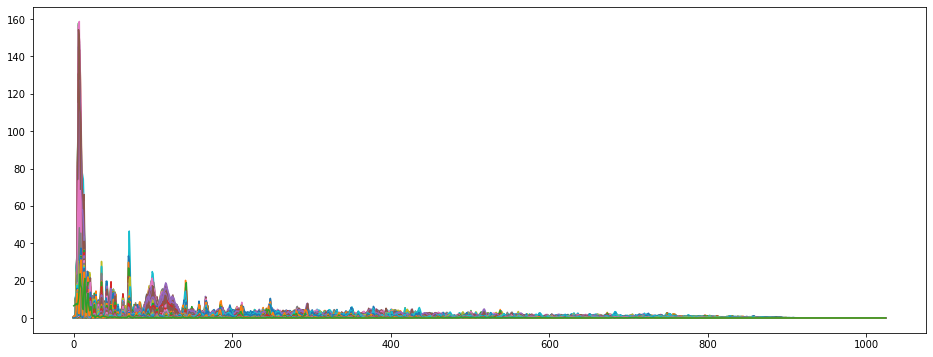

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(D);

**Espectrograma**

Un espectrograma es una representación visual del espectro de frecuencias de una señal a medida que varía con el tiempo. Cuando se aplican a una señal de audio, los espectrogramas a veces se denominan huellas de voz o diagramas de voz (wiki).

Aquí convertimos el eje de frecuencia a uno logarítmico.

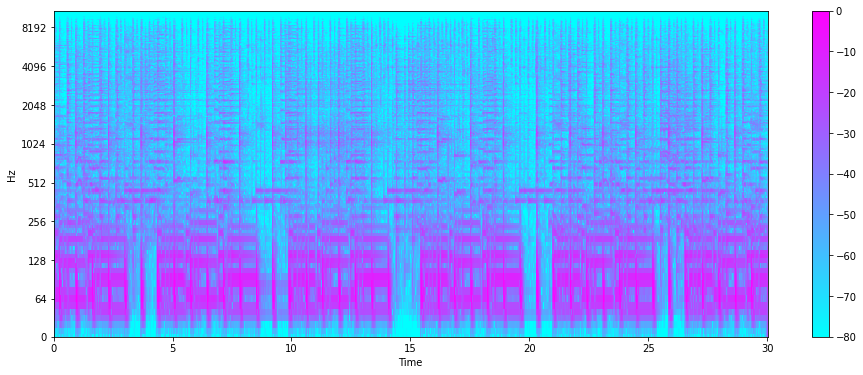

In [ ]:
# Convierta un espectrograma de amplitud en un espectrograma escalado en decibelios.
DB = librosa.amplitude_to_db(D, ref = np.max)

# creando el espectograma
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

**Espectrograma de Mel**

La Escala de Mel, matemáticamente hablando, es el resultado de alguna transformación no lineal de la escala de frecuencia. El espectrograma de Mel es un espectrograma normal, pero con una escala de Mel en el eje y. 

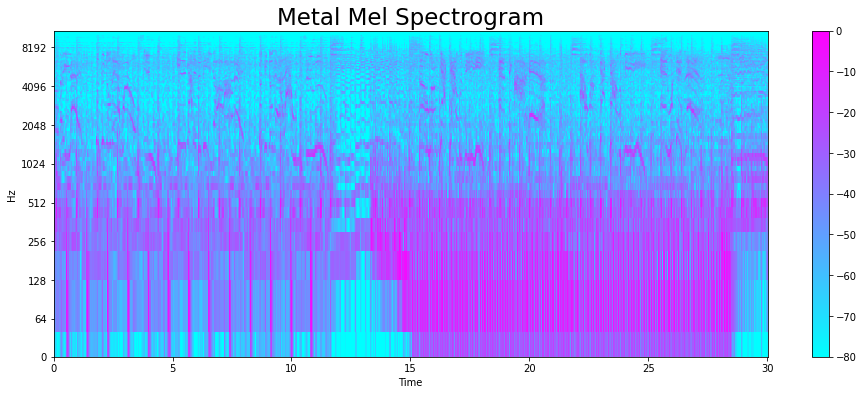

In [ ]:
y, sr = librosa.load(f'{general_path}/genres_original/metal/metal.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Metal Mel Spectrogram", fontsize = 23);

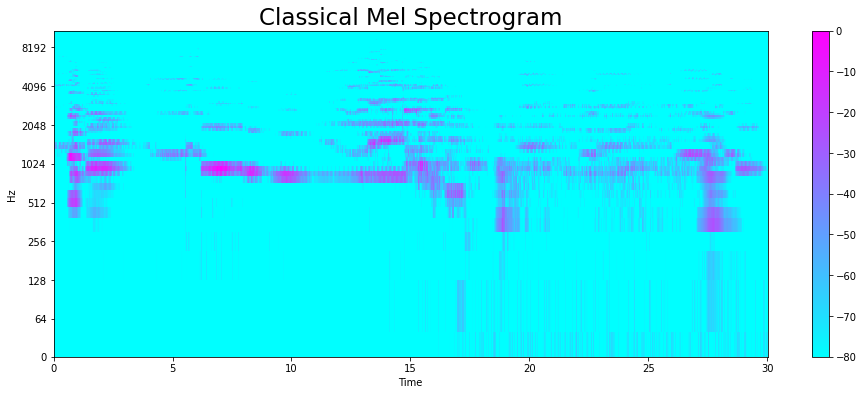

In [ ]:
y, sr = librosa.load(f'{general_path}/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Classical Mel Spectrogram", fontsize = 23);

**Funciones de audio**

Tasa de cruce por cero

la velocidad a la que la señal cambia de positiva a negativa o viceversa 

In [ ]:
# Total de cruces por cero en nuestra canción 1
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

39232


**Armónicos y Perceptuales**

Los armónicos son características que los oídos humanos no pueden distinguir (representan el color del sonido)

La onda de choque de comprensión perceptual representa el ritmo del sonido y la emoción. 

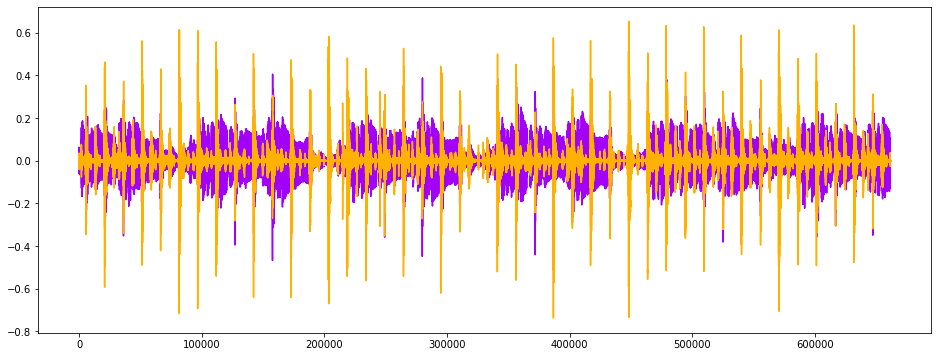

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

Tempo BPM (pulsaciones por minuto)
Rastreador de ritmo de programación di

In [ ]:
tempo, _ = librosa.beat.beat_track(y, sr = sr)
tempo

107.666015625

**Centroide espectral**

Indica dónde se encuentra el "centro de masa" de un sonido y se calcula como la media ponderada de las frecuencias presentes en el sonido. 

In [ ]:
# calcula el centroide espectral
spectral_centroids = librosa.feature.spectral_centroid(audio_file, sr=sr)[0]


print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Calculo de la variable de tiempo 
frames = range(len(spectral_centroids))

# Convierte recuentos de fotogramas en tiempo (segundos)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Función que normaliza los datos de sonido
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [1817.93364736 1953.08392985 2038.8113414  ...  766.50416352 1019.33192639
 1081.69931747] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


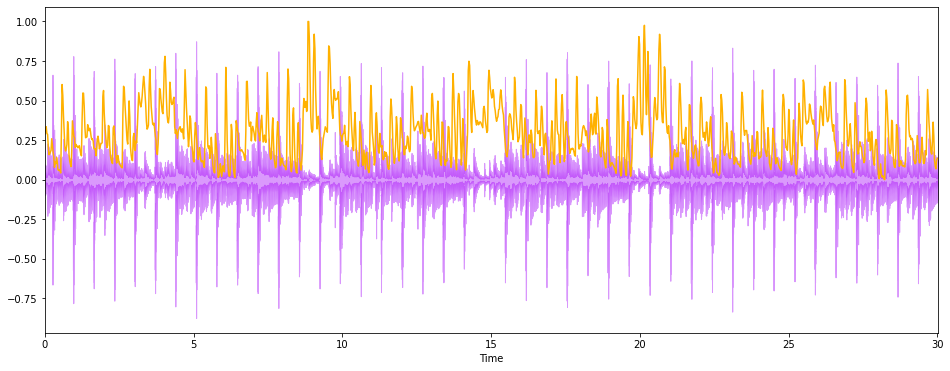

In [ ]:
#plotting del centroide espectral a lo largo de la forma de onda
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_centroids), color='#FFB100')

**Reducción espectral**

Es una medida de la forma de la señal. Representa la frecuencia por debajo de la cual un porcentaje específico de la energía espectral total, p. 85%, mentiras 

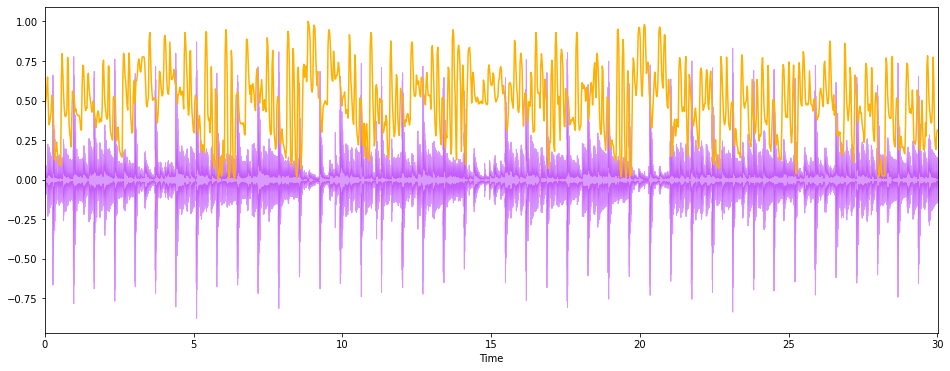

In [ ]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr)[0]


plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

**Coeficientes cepstrales de frecuencia Mel:**

Los coeficientes cepstrales de frecuencia de Mel (MFCC) de una señal son un pequeño conjunto de características (generalmente entre 10 y 20) que describen de manera concisa la forma general de una envolvente espectral. Modela las características de la voz humana. 

mfccs shape: (20, 1293)


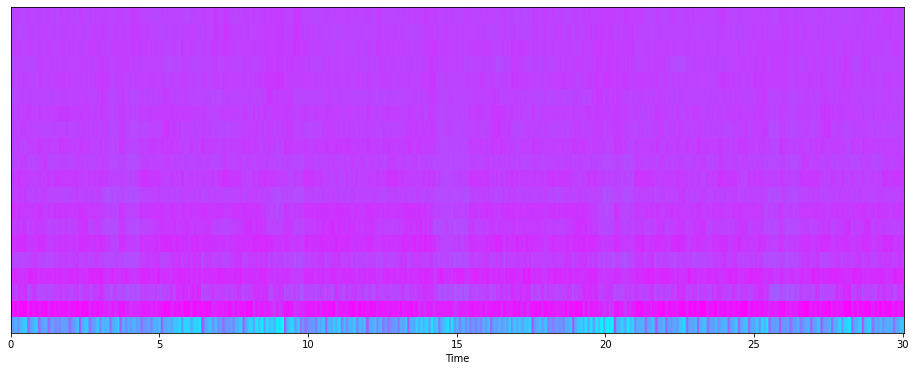

In [ ]:
mfccs = librosa.feature.mfcc(audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)


plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool')

Los datos deben escalarse: 

Mean: -5.9005373e-10 

Var: 1.0000001


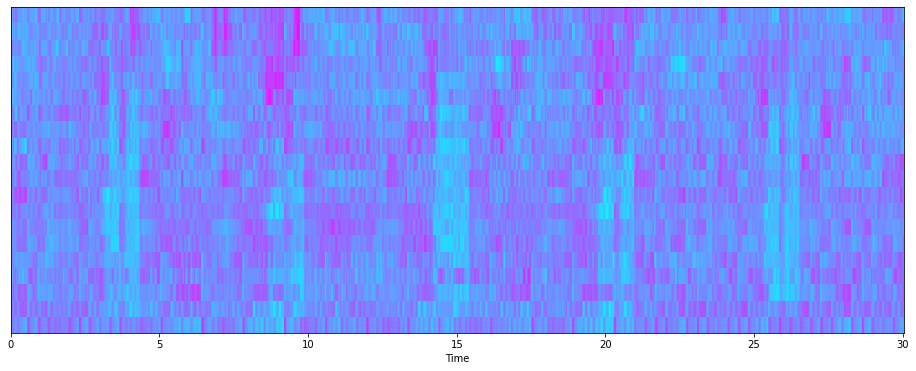

In [ ]:
# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

**Frecuencias cromáticas**

Las funciones de croma son una representación interesante y poderosa para el audio musical en el que todo el espectro se proyecta en 12 contenedores que representan los 12 semitonos distintos (o croma) de la octava musical. 

Chromogram shape: (12, 133)


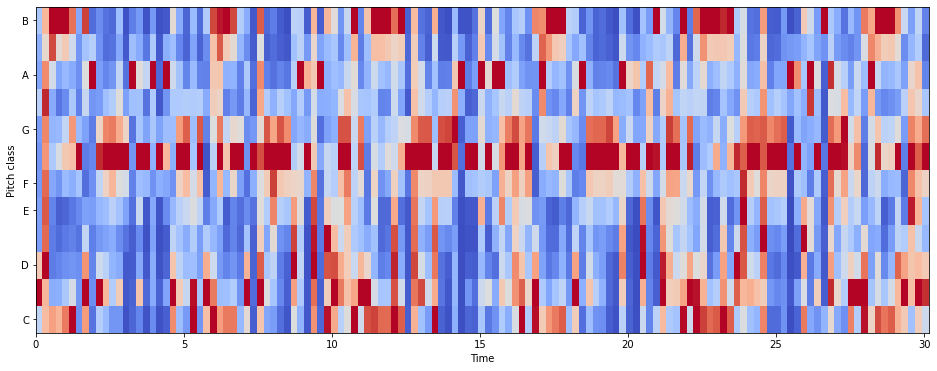

In [ ]:
# Aumente o disminuya hop_length para cambiar qué tan granular desea que sean sus datos
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

**EDA**

EDA se realizará en las características_30_sec.csv. Este archivo contiene la media y la varianza de cada archivo de audio de las funciones analizadas anteriormente.

Entonces, la tabla tiene un final de 1000 filas (10 géneros x 100 archivos de audio) y 60 características (dimensionalidades). 

In [ ]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.wav  661794          0.350088  ...     1.221291   46.936035  blues
1  blues.00001.wav  661794          0.340914  ...     0.531217   45.786282  blues
2  blues.00002.wav  661794          0.363637  ...    -2.231258   30.573025  blues
3  blues.00003.wav  661794          0.404785  ...    -3.407448   31.949339  blues
4  blues.00004.wav  661794          0.308526  ...   -11.703234   55.195160  blues

[5 rows x 60 columns]

Mapa de calor de correlación para medios de características 

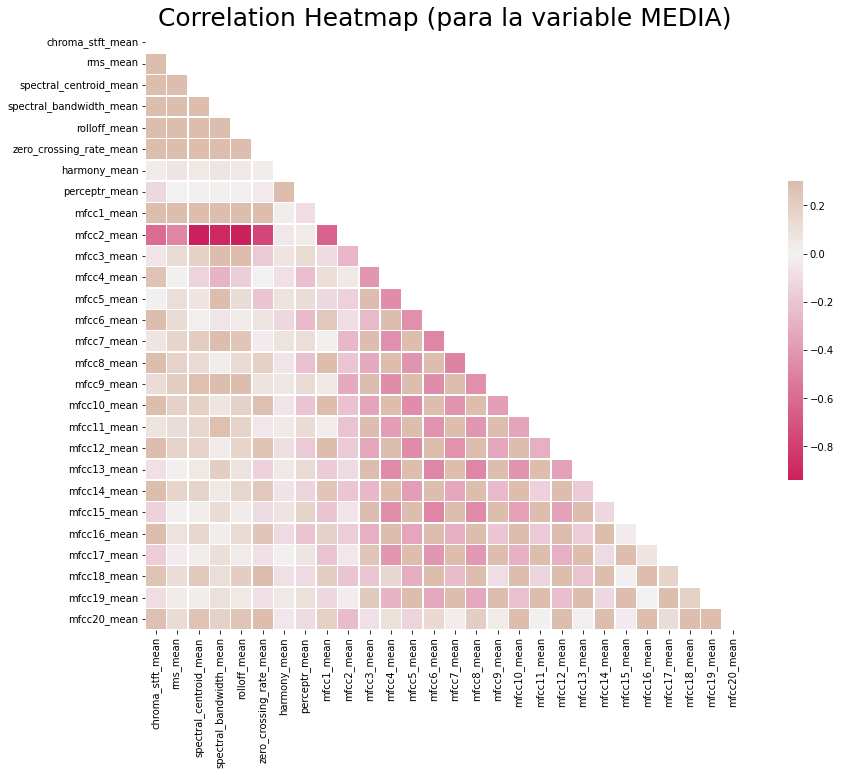

In [ ]:
# calcular la matriz de correlacion 
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

#
mask = np.triu(np.ones_like(corr, dtype=np.bool))


f, ax = plt.subplots(figsize=(16, 11));


cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (para la variable MEDIA)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

**Diagrama de caja para distribuciones de géneros**

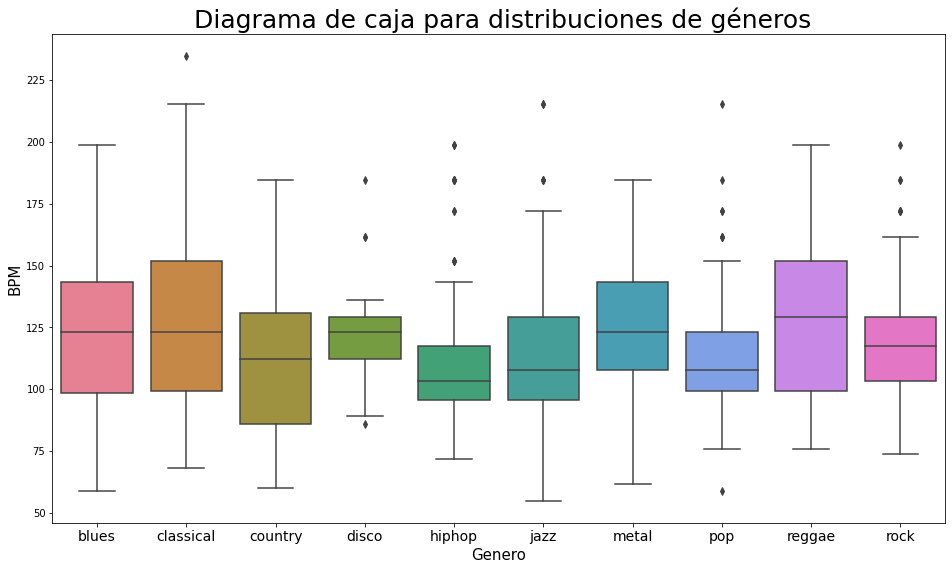

In [ ]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title(' Diagrama de caja para distribuciones de géneros', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genero", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")

**Análisis de Componentes Principales** - para visualizar posibles grupos de géneros

Normalización

**PCA**

El diagrama de dispersión 

In [ ]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']


cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)



from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])


finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

# 44.93 variance explained

array([0.2439355 , 0.21781804])

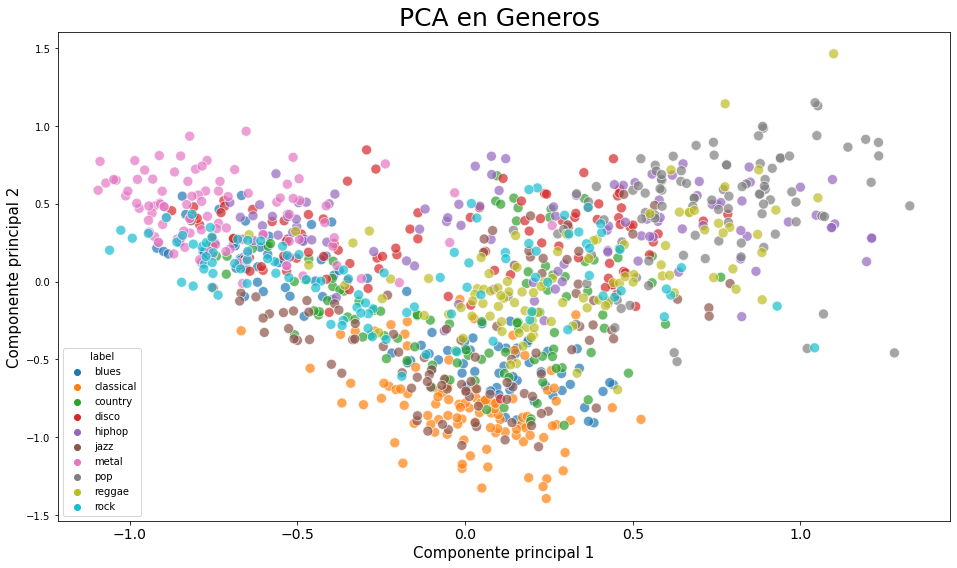

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA en Generos ', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Componente principal 1", fontsize = 15)
plt.ylabel("Componente principal 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

**Clasificación de aprendizaje automático**

Usando el archivo functions_3_sec.csv, podemos intentar crear un clasificador que prediga con precisión el género de cualquier entrada de archivo de audio nuevo. 

**Lectura en los datos**

Ahora intentemos predecir el género del audio usando técnicas de aprendizaje automático. 

In [ ]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

length  chroma_stft_mean  chroma_stft_var  ...  mfcc20_mean  mfcc20_var  label
0   66149          0.335406         0.091048  ...    -0.243027   43.771767  blues
1   66149          0.343065         0.086147  ...     5.784063   59.943081  blues
2   66149          0.346815         0.092243  ...     2.517375   33.105122  blues
3   66149          0.363639         0.086856  ...     3.630866   32.023678  blues
4   66149          0.335579         0.088129  ...     0.536961   29.146694  blues

[5 rows x 59 columns]

**Características y variable objetivo**

crea las variables objetivo y característica


In [ ]:
y = data['label'] 
X = data.loc[:, data.columns != 'label'] 



# Normalice para que todo esté en la misma escala.

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)


X = pd.DataFrame(np_scaled, columns = cols)

Dividir los datos en entrenamiento y prueba
70% - 30% dividido 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Creación de una función predefinida para evaluar la precisión de un modelo

la entrada es el modelo

ajusta el modelo en el conjunto de datos de entrenamiento predice sobre las características de prueba ycompara las predicciones con los datos reales 

In [ ]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

probando 6 modelos diferentes para evaluar su rendimiento

Probamos  modelos de clasificación, el modelo con mejor rendimiento fue KNN. 

In [ ]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=42)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=10)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")



Accuracy Naive Bayes : 0.51952 

Accuracy Stochastic Gradient Descent : 0.66133 

Accuracy KNN : 0.86253 

Accuracy Decission trees : 0.64498 

Accuracy Random Forest : 0.81415 

Accuracy Support Vector Machine : 0.75409 



Ahora se utilizara el modelo con mejor acierto, el cual fue KNN

Accuracy : 0.86253 



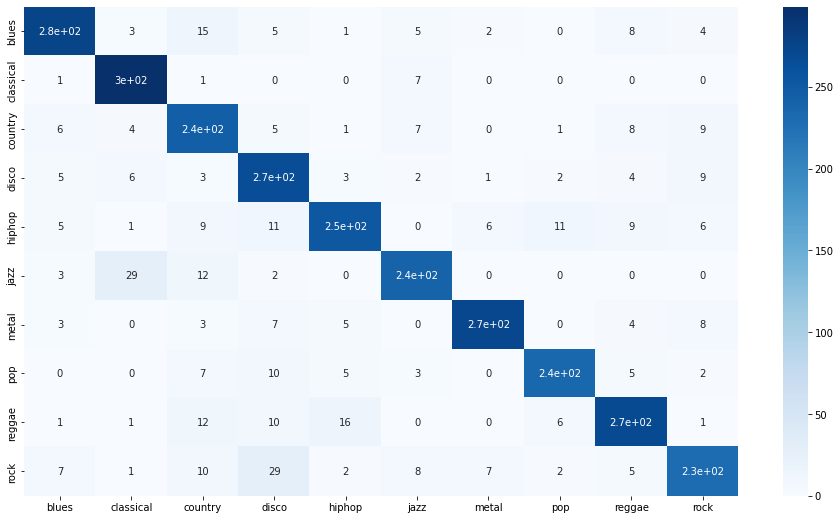

In [ ]:
# Modelo final
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)


preds = knn.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Matriz de confucion
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

Sistemas de recomendación**

Los sistemas "recomendadores" nos permiten encontrar la mejor similitud para cualquier vector dado, clasificados en orden descendente, desde la coincidencia más baja hasta la coincidencia menos óptima.

Para archivos de audio, esto se hará a través de la biblioteca cosine_similarity. 

In [ ]:
# Libraries
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

# Read data
data = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')

# Extract labels
labels = data[['label']]

# Drop labels from original dataframe
data = data.drop(columns=['length','label'])
data.head()

# Scale the data
data_scaled=preprocessing.scale(data)
print('Scaled data type:', type(data_scaled))

Scaled data type: <class 'numpy.ndarray'>


**Semejanza de coseno**


Calcula la similitud de coseno por pares para cada combinación de canciones en los datos. Esto da como resultado una matriz de 1000 x 1000 (con redundancia en la información como similitud del elemento A con el elemento B == similitud del elemento B con el elemento A). 

In [ ]:

similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

Similarity shape: (1000, 1000)


filename         blues.00000.wav  ...  rock.00099.wav
filename                          ...                
blues.00000.wav         1.000000  ...        0.304098
blues.00001.wav         0.049231  ...        0.311723
blues.00002.wav         0.589618  ...        0.321069
blues.00003.wav         0.284862  ...        0.183210
blues.00004.wav         0.025561  ...        0.061785

[5 rows x 1000 columns]

**Puntuación de similitud de canciones**

find_similar_songs() - es una función predefinida que toma el nombre de la canción y devuelve las 5 mejores coincidencias para esa canción. 

In [ ]:
def find_similar_songs(name):
    # Encuentra las canciones más similares a otra canción
    series = sim_df_names[name].sort_values(ascending = False)
    
    # Elimina la similitud del coseno == 1 (las canciones siempre tendrán la mejor coincidencia consigo mismas)
    series = series.drop(name)
    
    # Mostrar los 5 mejores resultados 
    print("\n*******\nCanciones similares a ", name)
    print(series.head(5))

In [ ]:
find_similar_songs('metal.00002.wav') 

ipd.Audio(f'{general_path}/genres_original/metal/metal.00002.wav')


*******
Canciones similares a  metal.00002.wav
filename
metal.00028.wav    0.904367
metal.00059.wav    0.896096
rock.00018.wav     0.891910
rock.00017.wav     0.886526
rock.00016.wav     0.867508
Name: metal.00002.wav, dtype: float64


In [ ]:
ipd.Audio(f'{general_path}/genres_original/metal/metal.00059.wav')

# Ahora utilizaremos algoritmo de aprendizaje profundo


con ayuda de keras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

In [ ]:
%matplotlib inline
from keras import layers
import keras

In [ ]:
df1 = pd.read_csv(f'{general_path}/features_3_sec.csv')
df1.head()


filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.0.wav   66149          0.335406  ...    -0.243027   43.771767  blues
1  blues.00000.1.wav   66149          0.343065  ...     5.784063   59.943081  blues
2  blues.00000.2.wav   66149          0.346815  ...     2.517375   33.105122  blues
3  blues.00000.3.wav   66149          0.363639  ...     3.630866   32.023678  blues
4  blues.00000.4.wav   66149          0.335579  ...     0.536961   29.146694  blues

[5 rows x 60 columns]

In [ ]:
df1.shape

(9990, 60)

In [ ]:
df1=df1.drop('filename',axis=1)

In [ ]:
genre_list = df1.iloc[:, -1]
encoder = LabelEncoder()

In [ ]:
y = encoder.fit_transform(genre_list)
print(y)

[0 0 0 ... 9 9 9]


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
from keras.models import Sequential
# Neural network
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
55/55 [==============================] - 2s 8ms/step - loss: 1.4588 - accuracy: 0.4869
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.8624 - accuracy: 0.7067
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.6770 - accuracy: 0.7729
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 0.5616 - accuracy: 0.8128
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 0.4799 - accuracy: 0.8434
Epoch 6/100
55/55 [==============================] - 0s 6ms/step - loss: 0.4049 - accuracy: 0.8677
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.3388 - accuracy: 0.8903
Epoch 8/100
55/55 [==============================] - 0s 7ms/step - loss: 0.2825 - accuracy: 0.9129
Epoch 9/100
55/55 [==============================] - 0s 7ms/step - loss: 0.2485 - accuracy: 0.9234
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.2048 - accuracy: 0.9399
Epoch 11/

In [ ]:
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 2ms/step - loss: 0.5936 - accuracy: 0.8962


Podemos observar que utlizando algoritmos de aprendizaje profundo, podemos obtener un mejor acierto 